In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.figsize']=(20,5)
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import pyarrow.parquet as pq

In [2]:
table = pq.read_table('D:/Data_Files/DLMS Load Profile/data.parquet')

# Convert it to a Pandas DataFrame (optional)
dframe = table.to_pandas()
dframe.head(1)
dframe['Kwh']=dframe['Kwh']/1000
dframe['time']=dframe['Clock']

In [3]:
len(dframe)

38366

In [4]:
df1=dframe.groupby('sensor')

In [60]:
lst=[]
for id,datafame in df1:
    df=datafame
    df['Clock']=pd.to_datetime(df['Clock'])
    df.set_index(['Clock'],inplace=True,drop= True)
    df = df[df.index >= '2022-11-18 00:00:00']
    # print(len(df))
    filtered_df = df[((df['R_Voltage'] == 0) | (df['Y_Voltage'] == 0) | (df['B_Voltage'] == 0)) & 
                     ((df['R_Current'] == 0) | (df['Y_Current'] == 0) | (df['B_Current'] == 0))]
    filtered_df['Kwh'] = 0
    df.loc[filtered_df.index, :] = filtered_df
    df=df[['Kwh']].resample(rule='30min').sum()
    df['id']=id
    # filtered_df=df[df['Kwh']<50]
    # filtered_df['Kwh'] = 100
    # df.loc[filtered_df.index, :] = filtered_df
    df['Kwh_r']=df['Kwh'].rolling(window=24).mean()
    df.dropna(inplace=True)
    # df=df.reset_index()
    
    lst.append(df)
    

In [61]:
df=lst[1]

<Axes: title={'center': '30min, rolling=12 '}, xlabel='Clock'>

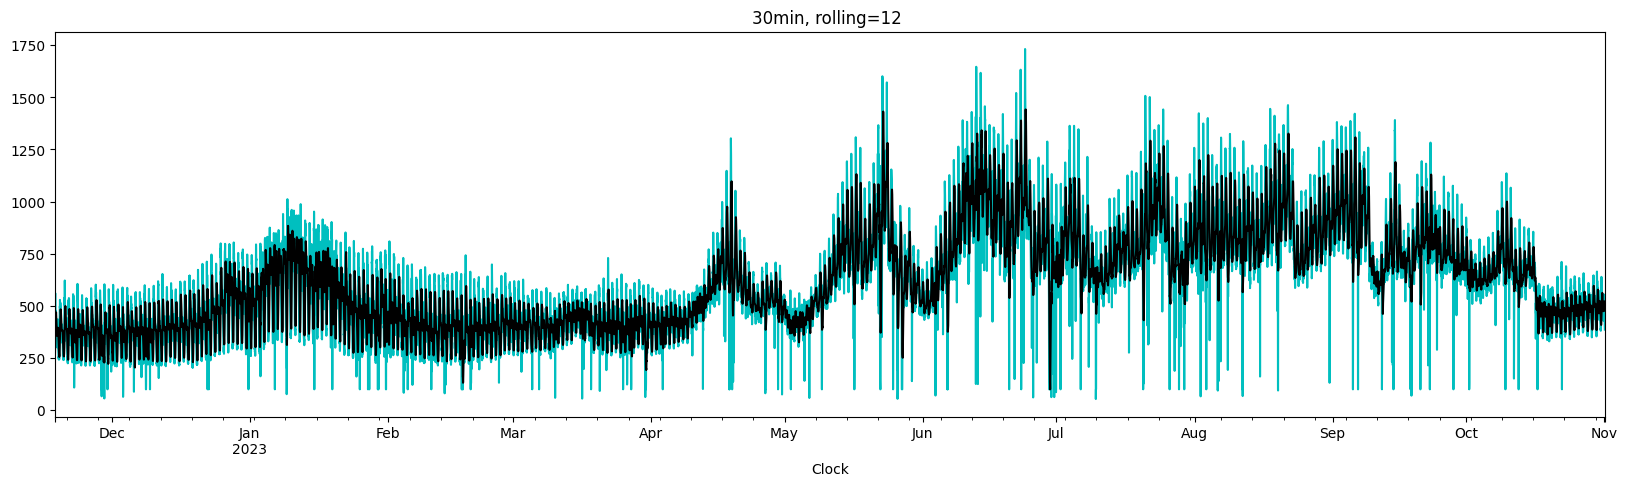

In [58]:
df['Kwh'].plot(color='c',title="30min, rolling=12 ")
df['Kwh_r'].plot(color='k')

<Axes: title={'center': '30min, rolling=24 '}, xlabel='Clock'>

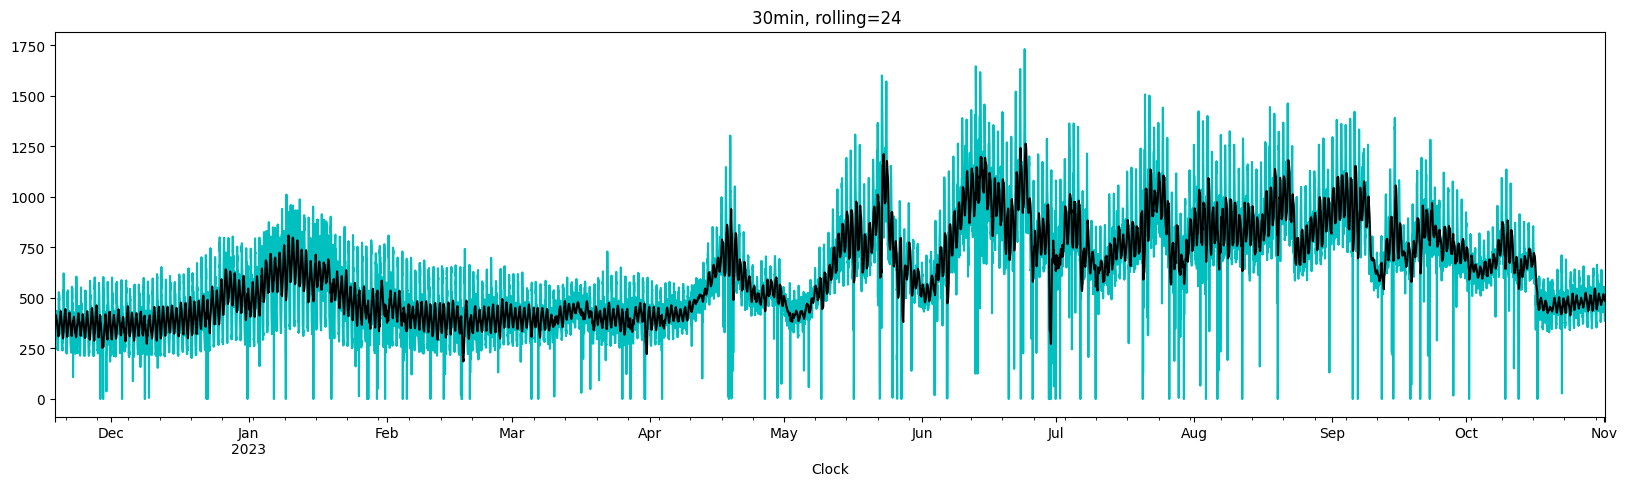

In [62]:
df['Kwh'].plot(color='c',title="30min, rolling=24 ")
df['Kwh_r'].plot(color='k')

<Axes: title={'center': '30min, rolling=12,kwh<50 =100 '}, xlabel='Clock'>

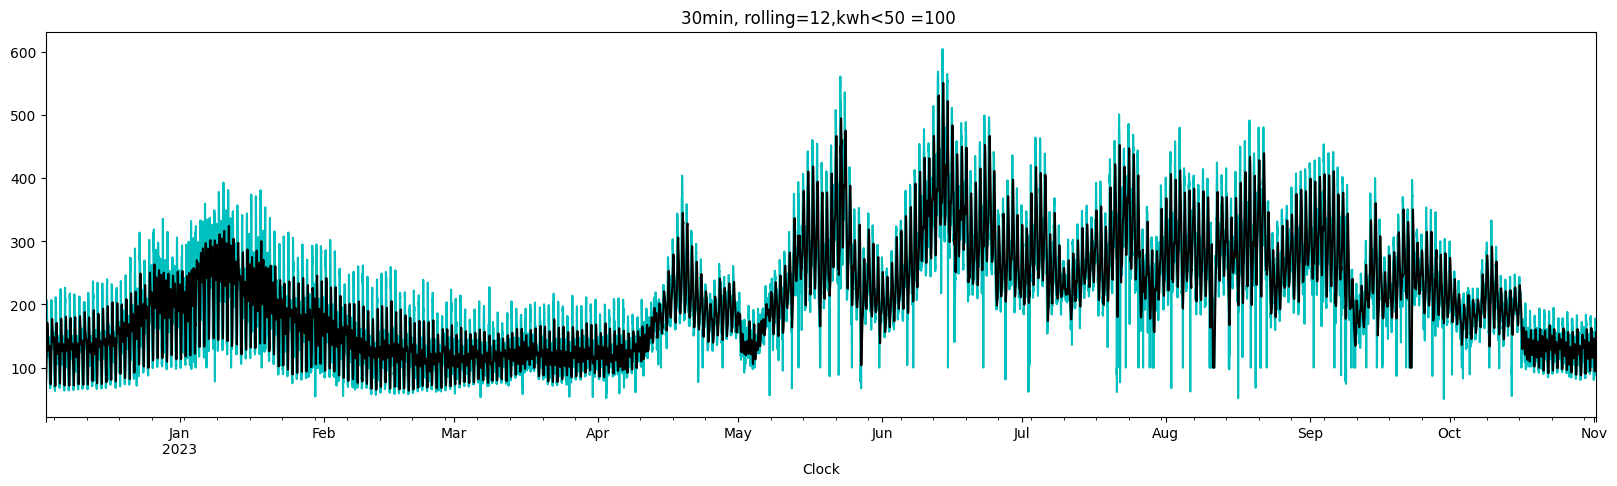

In [54]:
df['Kwh'].plot(color='c',title="30min, rolling=12,kwh<50 =100 ")
df['Kwh_r'].plot(color='k')

<Axes: title={'center': '30min, rolling=12,'}, xlabel='Clock'>

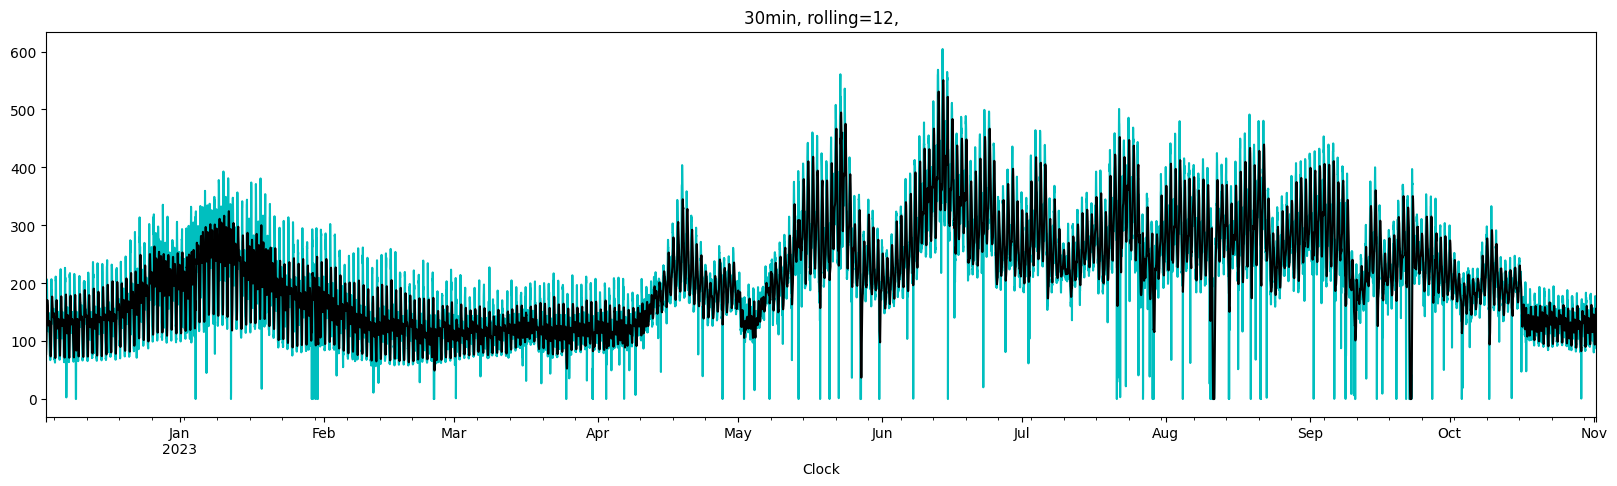

In [51]:
df['Kwh'].plot(color='c',title="30min, rolling=12,")
df['Kwh_r'].plot(color='k')

<Axes: title={'center': '30 min, rolling=24 '}, xlabel='Clock'>

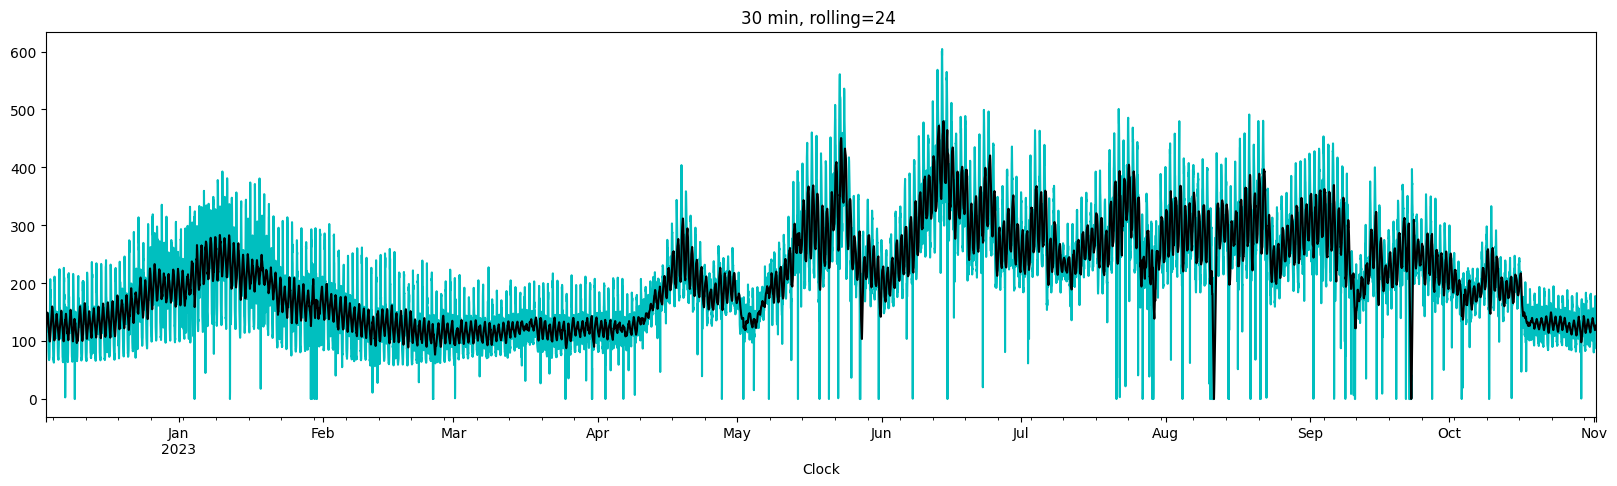

In [31]:
df['Kwh'].plot(color='c',title="30 min, rolling=24 ")
df['Kwh_r'].plot(color='k')

<Axes: title={'center': '30 min, rolling=48 '}, xlabel='Clock'>

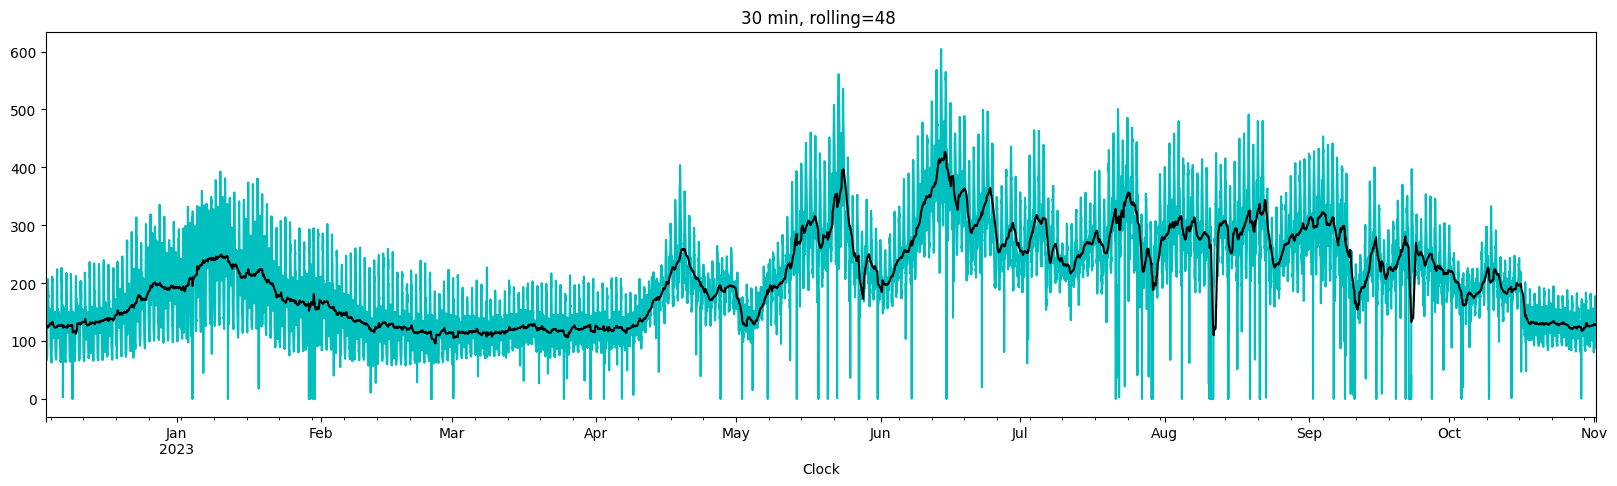

In [33]:
df['Kwh'].plot(color='c',title="30 min, rolling=48 ")
df['Kwh_r'].plot(color='k')

<Axes: title={'center': '30 min, rolling=24,kwh<50 =100 '}, xlabel='Clock'>

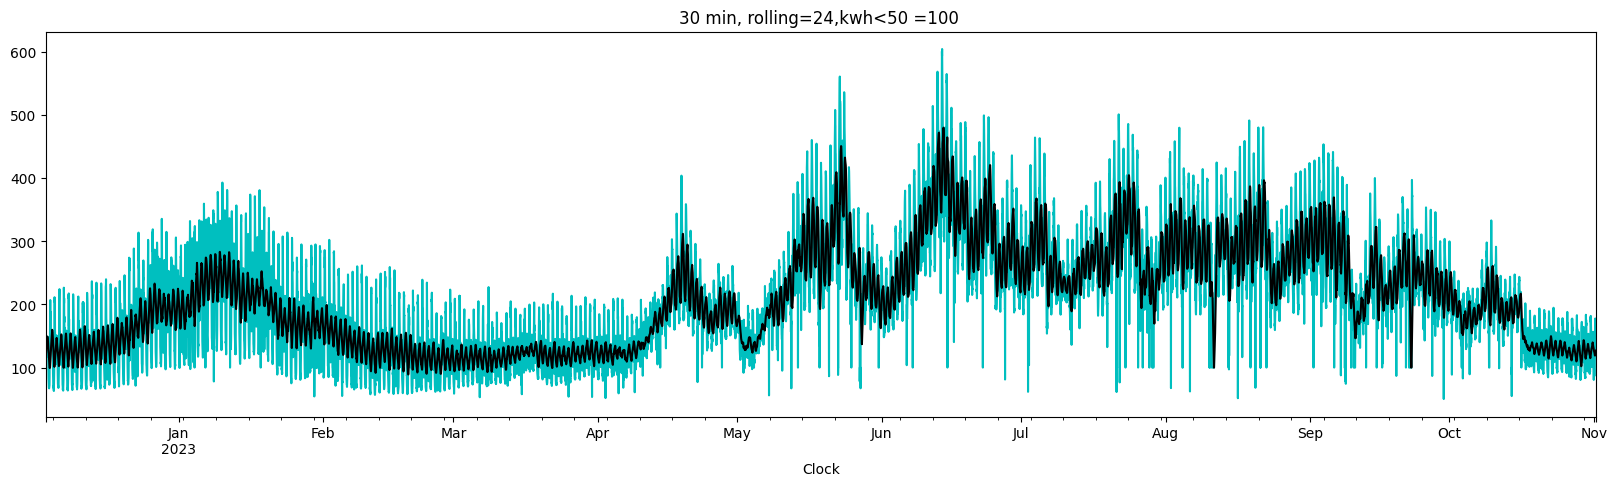

In [38]:
df['Kwh'].plot(color='c',title="30 min, rolling=24,kwh<50 =100 ")
df['Kwh_r'].plot(color='k')

<Axes: title={'center': '1H, rolling=24,kwh<100 =150 '}, xlabel='Clock'>

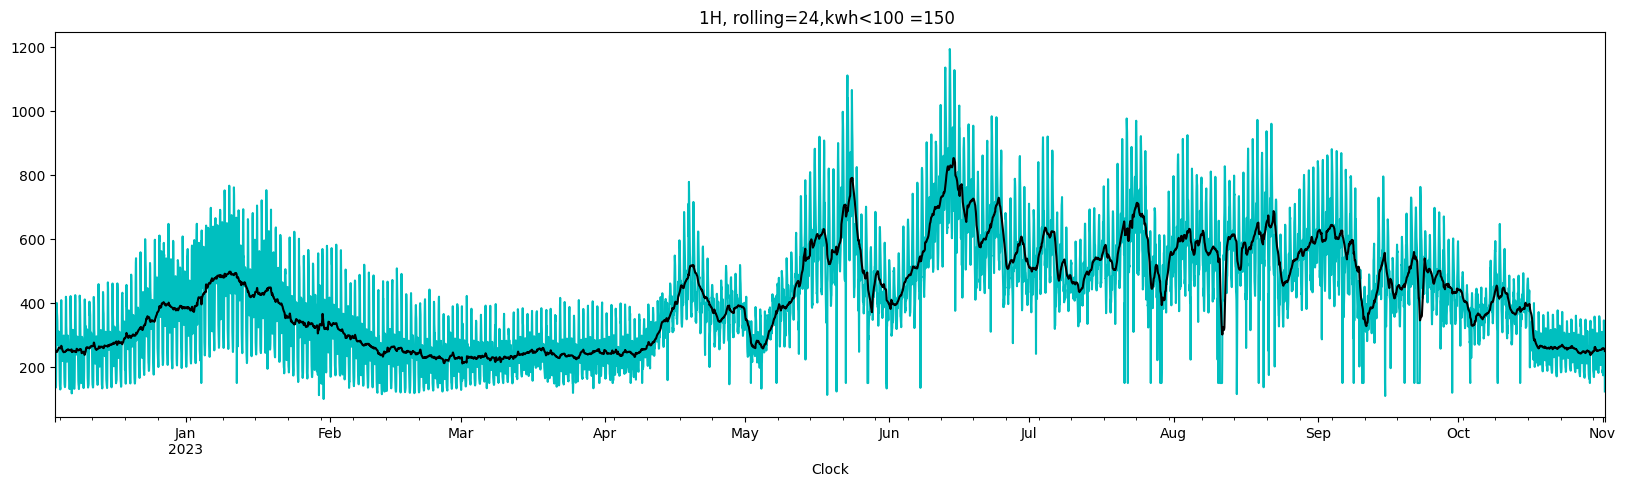

In [42]:
df['Kwh'].plot(color='c',title="1H, rolling=24,kwh<100 =150 ")
df['Kwh_r'].plot(color='k')

<Axes: title={'center': '1H, rolling=24,kwh<100 =200 '}, xlabel='Clock'>

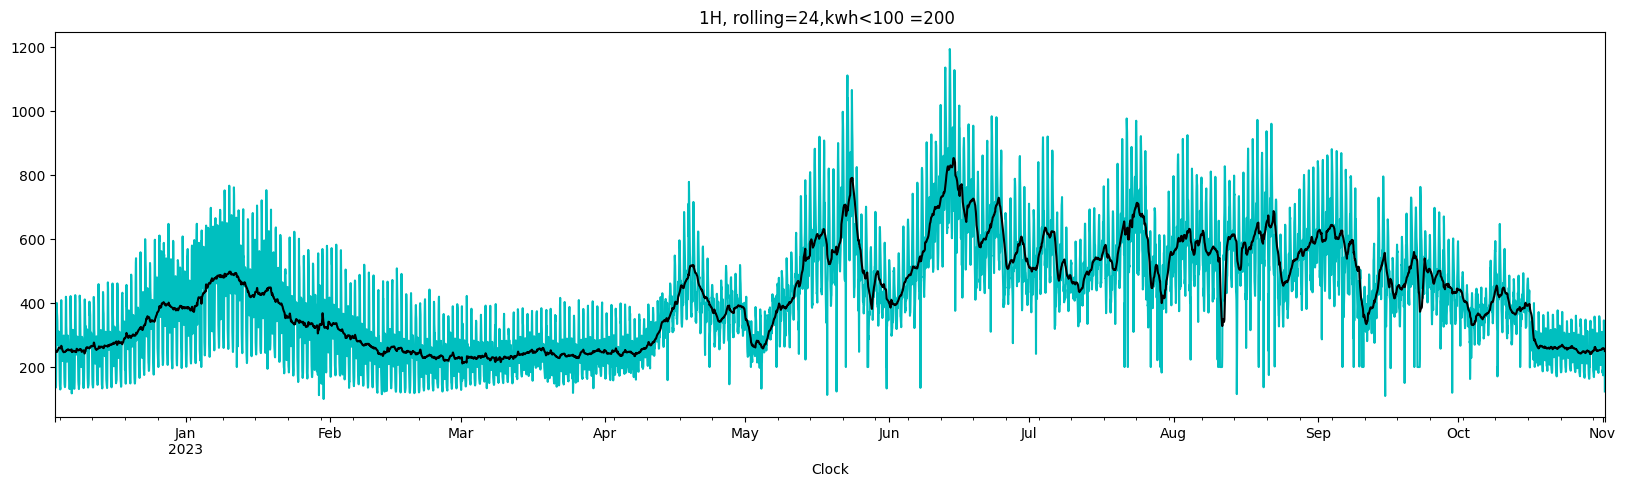

In [44]:
df['Kwh'].plot(color='c',title="1H, rolling=24,kwh<100 =200 ")
df['Kwh_r'].plot(color='k')

<Axes: title={'center': '1H, rolling=24,kwh<100 =250 '}, xlabel='Clock'>

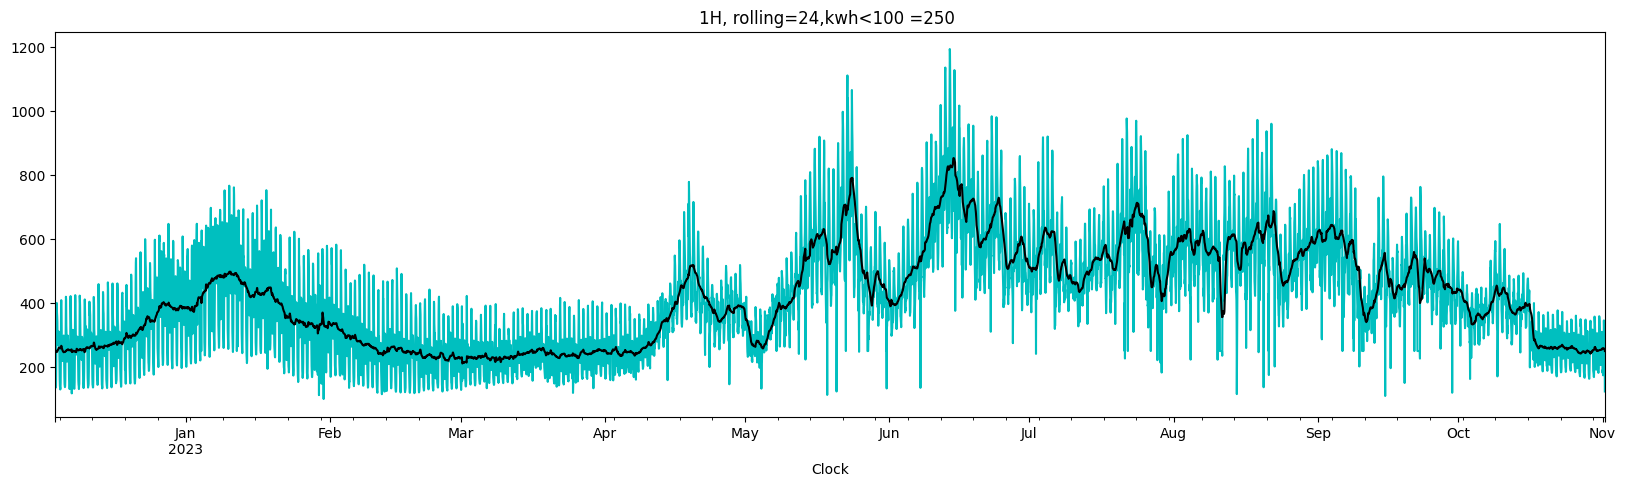

In [46]:
df['Kwh'].plot(color='c',title="1H, rolling=24,kwh<100 =250 ")
df['Kwh_r'].plot(color='k')

<Axes: title={'center': '1H, rolling=12,kwh<100 =150 '}, xlabel='Clock'>

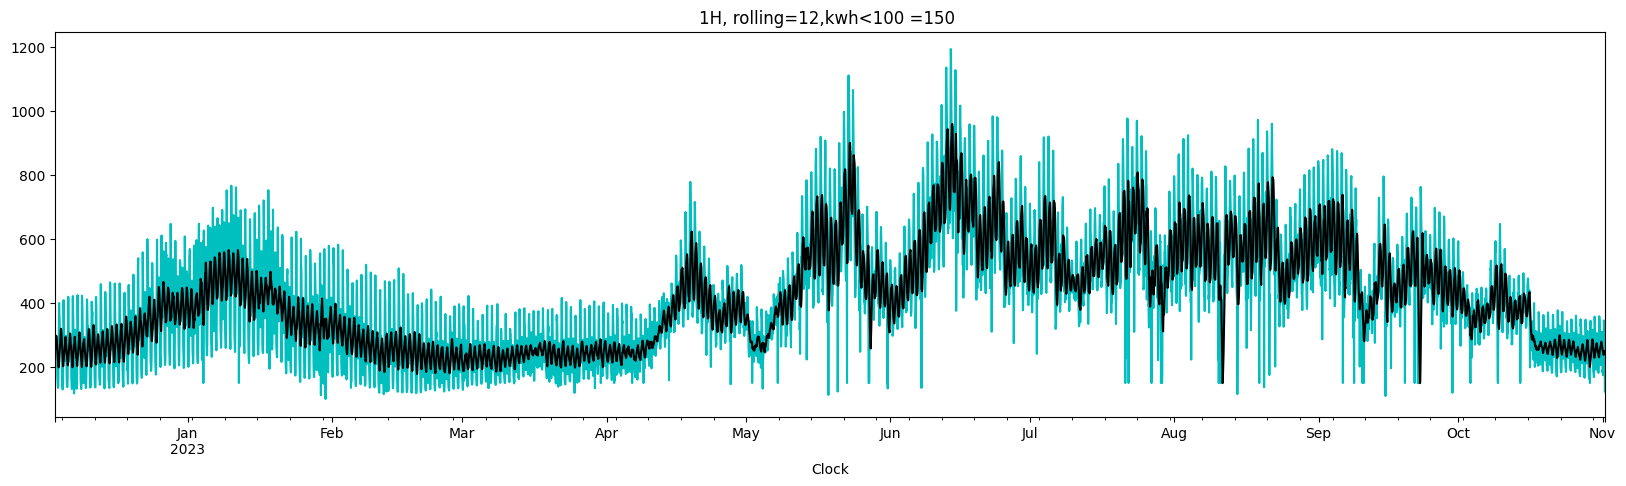

In [49]:
df['Kwh'].plot(color='c',title="1H, rolling=12,kwh<100 =150 ")
df['Kwh_r'].plot(color='k')

In [63]:

print(df['Kwh'].describe())
print()
print(df['Kwh_r'].describe())

result=adfuller(df['Kwh'],autolag='AIC')
print("kwh",'p-value:', result[1])

result=adfuller(df['Kwh_r'],autolag='AIC')
print("kwh_r",'p-value:', result[1])



count    16685.000000
mean       615.228816
std        254.794314
min          0.000000
25%        427.300000
50%        592.500000
75%        768.800000
max       1731.300000
Name: Kwh, dtype: float64

count    16685.000000
mean       615.183236
std        214.879470
min        186.045833
25%        431.325000
50%        580.308333
75%        771.125000
max       1263.320833
Name: Kwh_r, dtype: float64
kwh p-value: 0.05813988232977066
kwh_r p-value: 0.0179590333209588
